In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, special, linalg
%config Completer.use_jedi = False
import healpy as hp
import tqdm
import h5py
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
#mpl.rcParams['figure.figsize'] = (6, 4)

def shrink3d(data, height, width, depth):
    return data.reshape(height, int(data.shape[0]/height), width, int(data.shape[1]/width), depth, int(data.shape[2]/depth)).sum(axis=(1,3,5))

with h5py.File('./rvs_grid.h5', 'r') as g:
    
    # Load data
    box = {k:v[:] for k,v in g.items()}
    
    # Shrink along three axes
    lengthscale = 0.3
    lmax = 32
    nside = 16
    P, M, C = hp.nside2npix(nside), 20, 10
    P_original,M_original,C_original = box['counts'].shape[1:]
    print(f"Shrinking from {P_original,C_original,C_original} to {P,M,C}")
    L, H, R = 2 * lmax + 1, (lmax + 1) ** 2, 4 * nside - 1
    
    # Generate lengthscales
    lengthscale_m = lengthscale/((box['phot_rp_mean_mag'][1]-box['phot_rp_mean_mag'][0])*(M_original/M))
    lengthscale_c = lengthscale/((box['bp_rp'][1]-box['bp_rp'][0])*(C_original/C))
    print('Lengthscales',lengthscale_m,lengthscale_c)

    counts_shrunk = np.zeros((2, P, M, C))
    counts_shrunk[0] = shrink3d(box['counts'][0], P, M, C)
    counts_shrunk[1] = shrink3d(box['counts'][1], P, M, C)
    
    # Generate k and n, sorting by healpix
    nest_indices = hp.pixelfunc.ring2nest(nside, np.arange(P))
    box['k'] = counts_shrunk[1][nest_indices].astype(int)
    box['n'] = (counts_shrunk[0] + counts_shrunk[1])[nest_indices].astype(int)
    del counts_shrunk, box['counts']
    
    print(np.diff(box['phot_rp_mean_mag'][[0,-1]]))
    
%time %run GenerateSphHarm_decomposed_quick.py $nside $lmax

def pivoted_chol(get_diag, get_row, M, err_tol = 1e-6):
    """
    A simple python function which computes the Pivoted Cholesky decomposition/approximation of positive semi-definite operator. Only diagonal elements and select rows of that operator's matrix represenation are required.
    get_diag - A function which takes no arguments and returns the diagonal of the matrix when called.
    get_row - A function which takes 1 integer argument and returns the desired row (zero indexed).
    M - The maximum rank of the approximate decomposition; an integer. 
    err_tol - The maximum error tolerance, that is difference between the approximate decomposition and true matrix, allowed. Note that this is in the Trace norm, not the spectral or frobenius norm. 
    Returns: R, an upper triangular matrix of column dimension equal to the target matrix. It's row dimension will be at most M, but may be less if the termination condition was acceptably low error rather than max iters reached.
    """

    d = np.copy(get_diag())
    N = len(d)

    pi = list(range(N))

    R = np.zeros([M,N])

    err = np.sum(np.abs(d))

    m = 0
    while (m < M) and (err > err_tol):

        i = m + np.argmax([d[pi[j]] for j in range(m,N)])

        tmp = pi[m]
        pi[m] = pi[i]
        pi[i] = tmp

        R[m,pi[m]] = np.sqrt(d[pi[m]])
        Apim = get_row(pi[m])
        for i in range(m+1, N):
            if m > 0:
                ip = np.inner(R[:m,pi[m]], R[:m,pi[i]])
            else:
                ip = 0
            R[m,pi[i]] = (Apim[pi[i]] - ip) / R[m,pi[m]]
            d[pi[i]] -= pow(R[m,pi[i]],2)

        err = np.sum([d[pi[i]] for i in range(m+1,N)])
        m += 1

    R = R[:m,:]

    return(R)


# Important to copy as diag may not be writable depending on np version
def pivot_chol(A, M, err_tol = 1e-6):
    get_diag = lambda: np.diag(A).copy()
    get_row = lambda i: A[i,:]
    R = pivoted_chol(get_diag, get_row, M = M, err_tol = err_tol).T
    print(R.shape)
    return R

Shrinking from (49152, 30, 30) to (3072, 20, 10)
Lengthscales 0.6000000000000021 0.9999999999999998


 17%|█▋        | 182/1089 [00:00<00:00, 1819.23it/s]

[10.]


100%|██████████| 1089/1089 [00:00<00:00, 1949.34it/s]

CPU times: user 4.02 s, sys: 176 ms, total: 4.19 s
Wall time: 613 ms


# RVS (m,c)

In [ ]:
%%time
from cmdstanpy import CmdStanModel
magnitude_colour_model = CmdStanModel(stan_file='./StanModels/magnitude_colour.stan')

In [ ]:
box['k'].shape

In [ ]:
def shrink(data, rows, cols):
    return data.reshape(rows, int(data.shape[0]/rows), cols, int(data.shape[1]/cols)).sum(axis=1).sum(axis=2)

Nm, Nc = 20, 10

k = shrink(box['k'].sum(axis=0), Nm, Nc).T.flatten()
n = shrink(box['n'].sum(axis=0), Nm, Nc).T.flatten()

dx = np.arange(100)

lm = 3.0
Km = np.exp(-np.square(dx[:Nm,None]-dx[None,:Nm])/(2.0*lm*lm))
Lm = np.linalg.cholesky(Km+1e-15*np.diag(np.ones(Nm)))

lc = 3.0
Kc = np.exp(-np.square(dx[:Nc,None]-dx[None,:Nc])/(2.0*lc*lc))
Lc = np.linalg.cholesky(Kc+1e-15*np.diag(np.ones(Nc)))

magnitude_colour_data = {"Nm":Nm,
                         "Nc":Nc,
                         "Lm":Lm,
                         "Lc":Lc,
                         "k": k,
                         "n": n,
                         "mu":-5.0,
                         "sigma":1.0}

In [ ]:
%time fit_opt = magnitude_colour_model.optimize(data=magnitude_colour_data)

In [ ]:
plt.figure()
plt.imshow(special.expit(fit_opt.optimized_params_np[1+Nc*Nm:].reshape((Nc,Nm))),origin='lower',vmin=0,vmax=1)
plt.colorbar(orientation='horizontal')

In [ ]:
%time fit_vb = magnitude_colour_model.variational(data=magnitude_colour_data,iter=100000)

In [ ]:
fit_vb_x = fit_vb.variational_sample.values[:,203:]


In [ ]:
plt.figure()
plt.imshow(special.expit(np.median(fit_vb_x,axis=0).reshape((Nc,Nm))),origin='lower',vmin=0,vmax=1)
plt.colorbar(orientation='horizontal')

In [ ]:
x_vb = np.stack([fit_vb['sampler_params'][i] for i in range(Nm*Nc,2*Nm*Nc)]).reshape((Nc,Nm,1000))

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1)
ax1.imshow(special.expit(np.median(x_vb,axis=2)),origin='lower',aspect='auto')
ax2.imshow(np.std(x_vb,axis=2),origin='lower',aspect='auto',vmin=-1,vmax=1,cmap='RdBu_r')


In [ ]:

%time fit_hmc = magnitude_colour_model.sample(data=magnitude_colour_data, iter_warmup=500, iter_sampling=500, chains=1, show_progress = 'notebook')

# RVS - position

In [ ]:

lmax = 20

k = box['k'][:,:6,:].sum(axis=(1,2))
n = box['n'][:,:6,:].sum(axis=(1,2))

%time %run GenerateSphHarm_decomposed_quick.py $nside $lmax

data = {}
with h5py.File('./sphericalharmonics_decomposed_quick_nside{0}_lmax{1}.h5'.format(nside,lmax), 'r') as hf:
    for key in hf.keys():
        data[key] = hf[key][...]
        
lower, upper = np.zeros(2*lmax+1),np.zeros(2*lmax+1)
for i, _m in enumerate(range(-lmax,lmax+1)):
    match = np.where(m==_m)[0]
    lower[i] = match[0]
    upper[i] = match[-1]

position_data = {"J":hp.nside2npix(nside),
                 "N":data['lambda'].shape[1],
                 "H":data['m'].shape[0],
                 "L":2*lmax+1,
                 "k": k.astype(int),
                 "n": n.astype(int),
                 "lambda":data['lambda'].T,
                 "azimuth":data['azimuth'],
                 "indices":data['jpix']+1,
                 "lower":lower.astype(int)+1,
                 "upper":upper.astype(int)+1}

In [ ]:
%time position_model = CmdStanModel(stan_file='./StanModels/position.stan')

In [ ]:
%%time
from cmdstanpy import CmdStanModel
#position_model = CmdStanModel(stan_file='./StanModels/position.stan')
%time position_profile_model = CmdStanModel(stan_file='./StanModels/position_profile.stan')
%time position_profile_best_model = CmdStanModel(stan_file='./StanModels/position_profile_best.stan')

In [ ]:
%time fit_hmc = position_profile_best_model.sample(data=position_data, iter_warmup=500, iter_sampling=500, chains=1, show_progress = 'notebook')

In [ ]:
%time fit_hmc = position_profile_model.sample(data=position_data, iter_warmup=500, iter_sampling=500, chains=1, show_progress = 'notebook')

In [ ]:
%time fit_opt = position_model.optimize(data=position_data)

In [ ]:
opt_x = fit_opt.optimized_params_np[1+position_data['H']:]

In [ ]:
hp.mollview(special.expit(opt_x),min=0,max=1)

In [ ]:
%time fit_vb = position_model.variational(data=position_data,iter=100000)

In [ ]:
fit_vb_x = fit_vb.variational_sample.values[:,3+position_data['H']:]

In [ ]:
%time fit_hmc = position_model.sample(data=position_data, iter_warmup=500, iter_sampling=500, chains=1, show_progress = 'notebook')

In [ ]:
fit_hmc.summary()

In [ ]:
fit_hmc_x = fit_hmc.draws()[:,0,7+position_data['H']:]

In [ ]:
hp.mollview(special.expit(np.median(fit_hmc_x,axis=0)),min=0,max=1)

# Magnitude and position

In [ ]:
lmax = 100

k = box['k'].sum(axis=2)
n = box['n'].sum(axis=2)

%time %run GenerateSphHarm_decomposed_quick.py $nside $lmax

data = {}
with h5py.File('./sphericalharmonics_decomposed_quick_nside{0}_lmax{1}.h5'.format(nside,lmax), 'r') as hf:
    for key in hf.keys():
        data[key] = hf[key][...]
        
lower, upper = np.zeros(2*lmax+1),np.zeros(2*lmax+1)
for i, _m in enumerate(range(-lmax,lmax+1)):
    match = np.where(m==_m)[0]
    lower[i] = match[0]
    upper[i] = match[-1]
    
dx = np.arange(100)

lm = 10.0
Km = np.exp(-np.square(dx[:Nm,None]-dx[None,:Nm])/(2.0*lm*lm))
Lm = np.linalg.cholesky(Km+1e-15*np.diag(np.ones(Nm)))

magnitude_position_data = {"J":hp.nside2npix(nside),
                 "N":data['lambda'].shape[1],
                 "H":data['m'].shape[0],
                 "L":2*lmax+1,
                 "k": k.astype(int).T,
                 "n": n.astype(int).T,
                 "lambda":data['lambda'].T,
                 "azimuth":data['azimuth'],
                 "indices":data['jpix']+1,
                 "lower":lower.astype(int)+1,
                 "upper":upper.astype(int)+1,
                 "Nm":Nm,
                 "Lm":Lm,
                 "mu":0.0,
                 "sigma":1.0,
                 "sigmal":1.0/np.power(1.0+data['l'],1.5)}


In [ ]:
plt.plot(special.expit(fit_opt_x),alpha = 0.1,color='skyblue',lw=1);

In [ ]:
n.shape

In [ ]:
%time magnitude_position_model = CmdStanModel(stan_file='./StanModels/magnitude_position.stan')

In [ ]:
%time fit_opt = magnitude_position_model.optimize(data=magnitude_position_data,inits=0,output_dir='./StanOutput')

In [ ]:
fit_opt_x = fit_opt.optimized_params_np[1+magnitude_position_data['Nm']*magnitude_position_data['H']:].reshape((magnitude_position_data['J'],magnitude_position_data['Nm'])).T

In [ ]:
hp.mollview((k[:,31]+1)/(n[:,31]+2),min=0,max=1,coord=['C','G'])

In [ ]:
hp.mollview(special.expit(fit_opt_x[31]),min=0,max=1,coord=['C','G'])

In [ ]:
%time fit_hmc = magnitude_position_model.sample(data=magnitude_position_data, iter_warmup=1, iter_sampling=1, inits=0, chains=4, show_progress = 'notebook')

# Demo

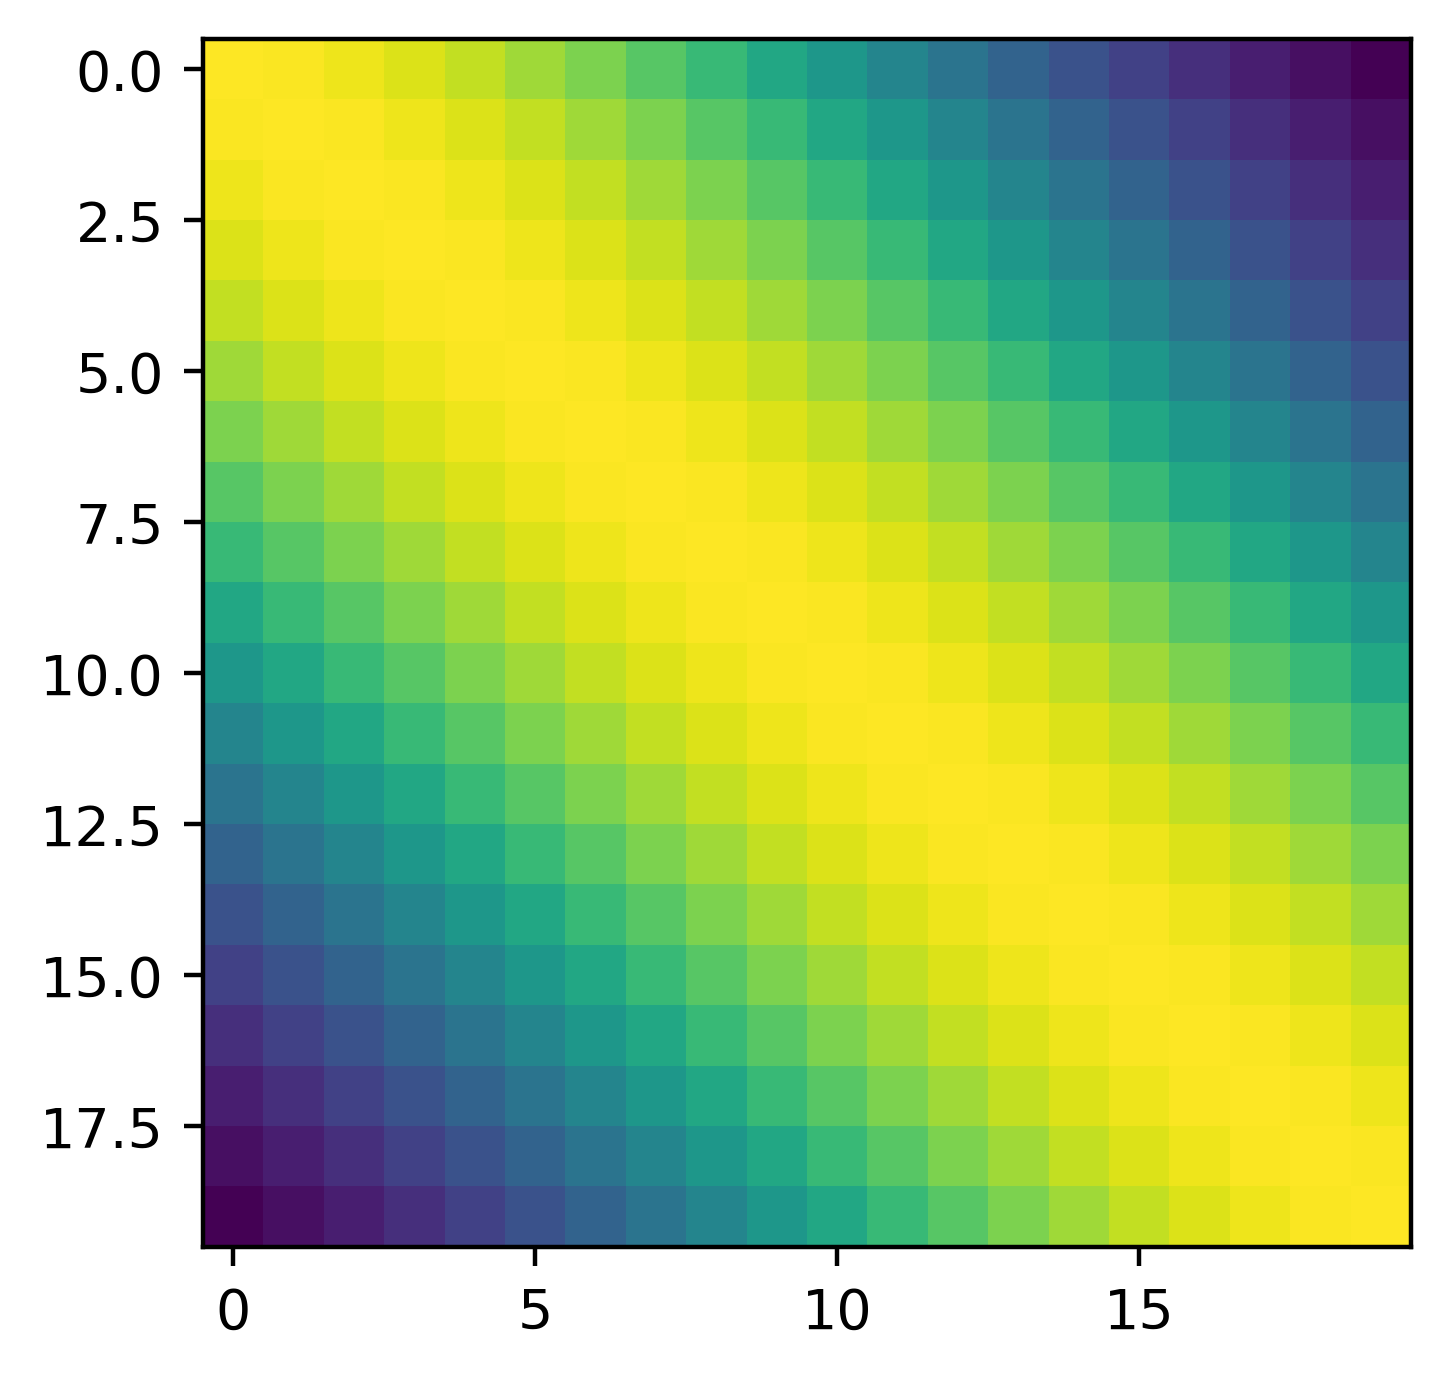

In [129]:
dx = np.arange(100)

covariance = np.exp(-np.square(dx[:M,None]-dx[None,:M])/(2.0*10.0**2.0))
cholesky = np.linalg.cholesky(covariance+1e-15*np.diag(np.ones(M)))
plt.imshow(covariance)

# Magnitude/Colour/Position

In [2]:
from cmdstanpy import CmdStanModel
%time mcp_model = CmdStanModel(stan_file='./StanModels/magnitude_colour_position.stan')
%time mcps_model = CmdStanModel(stan_file='./StanModels/magnitude_colour_position_sparse.stan')
%time mcpp_model = CmdStanModel(stan_file='./StanModels/magnitude_colour_position_pivot.stan')
%time mcpsp_model = CmdStanModel(stan_file='./StanModels/magnitude_colour_position_sparse_pivot.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/douglasboubert/Science/gaia-selection-function/astrometry/SphHarmonics/StanModels/magnitude_colour_position
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/douglasboubert/Science/gaia-selection-function/astrometry/SphHarmonics/StanModels/magnitude_colour_position_sparse
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/douglasboubert/Science/gaia-selection-function/astrometry/SphHarmonics/StanModels/magnitude_colour_position_pivot
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/douglasboubert/Science/gaia-selection-function/astrometry/SphHarmonics/StanModels/magnitude_colour_position_sparse_pivot


CPU times: user 1.16 ms, sys: 363 µs, total: 1.52 ms
Wall time: 1.88 ms
CPU times: user 1.54 ms, sys: 794 µs, total: 2.33 ms
Wall time: 2.16 ms
CPU times: user 2.36 ms, sys: 1.04 ms, total: 3.39 ms
Wall time: 3.24 ms
CPU times: user 2.33 ms, sys: 1.18 ms, total: 3.51 ms
Wall time: 3.5 ms


In [125]:
np.where(np.abs(sphox['lambda'])<1e-3)[0].size/sphox['lambda'].size

0.16951623012229072

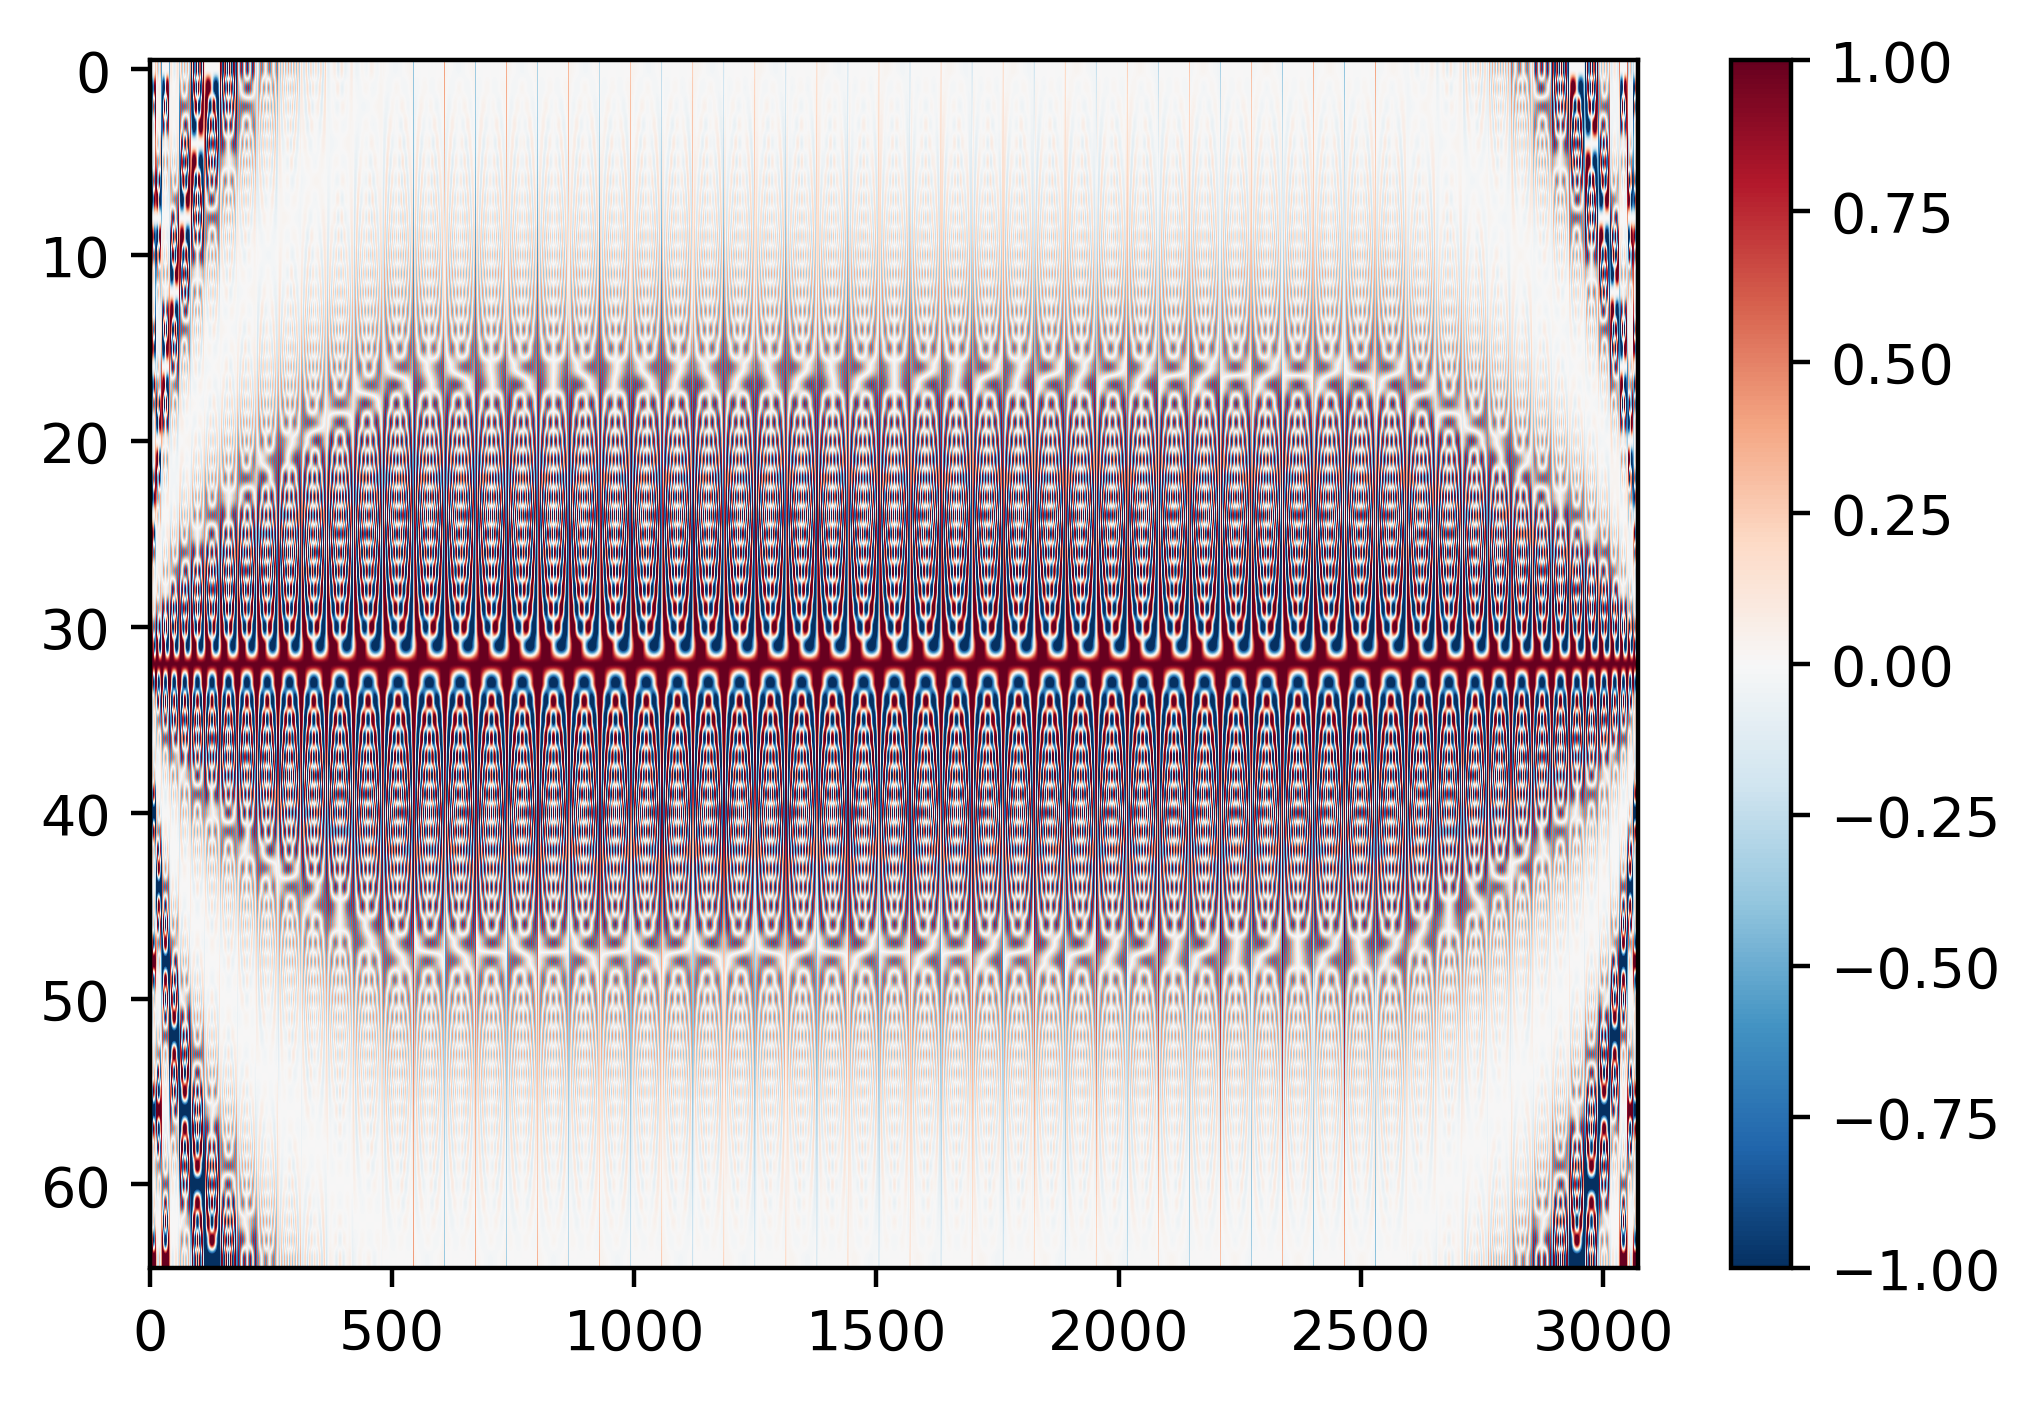

In [126]:
plt.imshow(sphox['azimuth'],aspect='auto',vmin=-1,vmax=1,cmap='RdBu_r')
plt.colorbar()

In [40]:
with h5py.File(f'./SphericalHarmonics/sphericalharmonics_decomposed_quick_nside{nside}_lmax{lmax}.h5', 'r') as f:
    sphox = {k:v[:] for k,v in f.items()}
        
    
dx = np.arange(100)
zero_sigma = 2.0
threshold = 0.01#np.exp(-zero_sigma**2.0/2.0)

covariance_m = np.exp(-np.square(dx[:M,None]-dx[None,:M])/(2.0*lengthscale_m**2.0))
cholesky_m = np.linalg.cholesky(covariance_m+1e-15*np.diag(np.ones(M)))

covariance_c = np.exp(-np.square(dx[:C,None]-dx[None,:C])/(2.0*lengthscale_c**2.0))
cholesky_c = np.linalg.cholesky(covariance_c+1e-15*np.diag(np.ones(C)))

mcp_data = {"P":P, "M":M, "C":C, "L":L, "H":H, "R":R,
            "lambda":sphox['lambda'].T, "azimuth":sphox['azimuth'],
            "pixel_to_ring":sphox['jpix']+1, "lower":sphox['lower'].astype(int)+1, "upper":sphox['upper'].astype(int)+1,
            "cholesky_m":cholesky_m.copy(), "cholesky_c_T":cholesky_c.T.copy(),
            "mu":np.zeros(H), "sigma":1.0/np.power(1.0+sphox['l'],1.5),
            "k": np.moveaxis(box['k'],0,2), "n": np.moveaxis(box['n'],0,2)}

cholesky_m[cholesky_m < threshold] = 0.0
cholesky_nonzero_m = np.where(cholesky_m > 0.0)[0].size
print(100*cholesky_nonzero_m/(M*M))

cholesky_c[cholesky_c < threshold] = 0.0
cholesky_nonzero_c = np.where(cholesky_c > 0.0)[0].size
print(100*cholesky_nonzero_c/(C*C))

mcps_data = {"P":P, "M":M, "C":C, "L":L, "H":H, "R":R,
            "lambda":sphox['lambda'].T, "azimuth":sphox['azimuth'],
            "pixel_to_ring":sphox['jpix']+1, "lower":sphox['lower'].astype(int)+1, "upper":sphox['upper'].astype(int)+1,
            "cholesky_m":cholesky_m, "cholesky_c":cholesky_c,"cholesky_nonzero_m":cholesky_nonzero_m, "cholesky_nonzero_c":cholesky_nonzero_c,
            "mu":np.zeros(H), "sigma":1.0/np.power(1.0+sphox['l'],1.5),
            "k": np.moveaxis(box['k'],0,2), "n": np.moveaxis(box['n'],0,2)}

pivot_err_tol = 1e-4
pivot_m = pivot_chol(covariance_m, M=M, err_tol=pivot_err_tol)
pivot_c = pivot_chol(covariance_c, M=C, err_tol=pivot_err_tol)
M_pivot = pivot_m.shape[1]
C_pivot = pivot_c.shape[1]
print(M,M_pivot)
print(C,C_pivot)

mcpp_data = {"P":P, "M":M, "C":C, "L":L, "H":H, "R":R,
            "lambda":sphox['lambda'].T, "azimuth":sphox['azimuth'],
            "pixel_to_ring":sphox['jpix']+1, "lower":sphox['lower'].astype(int)+1, "upper":sphox['upper'].astype(int)+1,
            "M_pivot":M_pivot, "C_pivot":C_pivot, "cholesky_m":pivot_m, "cholesky_c":pivot_c,
            "mu":np.zeros(H), "sigma":1.0/np.power(1.0+sphox['l'],1.5),
            "k": np.moveaxis(box['k'],0,2), "n": np.moveaxis(box['n'],0,2)}

sparse_tol = 1e-4

sparse_pivot_m = pivot_m.copy()
for m in range(M):
    max_row = max(np.abs(sparse_pivot_m[m]))
    sparse_pivot_m[m,np.abs(sparse_pivot_m[m])/max_row < sparse_tol] = 0.0
sparse_pivot_nonzero_m = np.where(sparse_pivot_m != 0.0)[0].size
print(100*sparse_pivot_nonzero_m/(M*M_pivot))

sparse_pivot_c = pivot_c.copy()
for c in range(C):
    max_row = max(np.abs(sparse_pivot_c[c]))
    sparse_pivot_c[c,np.abs(sparse_pivot_c[c])/max_row < sparse_tol] = 0.0
sparse_pivot_nonzero_c = np.where(sparse_pivot_c != 0.0)[0].size
print(100*sparse_pivot_nonzero_c/(C*C_pivot))


mcpsp_data = {"P":P, "M":M, "C":C, "L":L, "H":H, "R":R,
            "lambda":sphox['lambda'].T, "azimuth":sphox['azimuth'],
            "pixel_to_ring":sphox['jpix']+1, "lower":sphox['lower'].astype(int)+1, "upper":sphox['upper'].astype(int)+1,
            "M_pivot":M_pivot, "C_pivot":C_pivot, "cholesky_nonzero_m":sparse_pivot_nonzero_m, "cholesky_nonzero_c":sparse_pivot_nonzero_c,
             "cholesky_m":sparse_pivot_m, "cholesky_c":sparse_pivot_c,
            "mu":np.zeros(H), "sigma":1.0/np.power(1.0+sphox['l'],1.5),
            "k": np.moveaxis(box['k'],0,2), "n": np.moveaxis(box['n'],0,2)}




9.75
34.0
(20, 20)
(10, 10)
20 20
10 10
18.25
45.0


In [8]:
np.where(sparse_pivot_m != 0.0)[0].size

170

In [41]:
#%time mcp_opt = mcp_model.optimize(data=mcp_data,output_dir='./StanOutput',inits=0)
#%time mcps_opt = mcps_model.optimize(data=mcps_data,output_dir='./StanOutput',inits=0)
#%time mcpp_opt = mcpp_model.optimize(data=mcpp_data,output_dir='./StanOutput',inits=0)
%time mcpsp_opt = mcpsp_model.optimize(data=mcpsp_data,output_dir='./StanOutput',inits=0)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


CPU times: user 2.94 s, sys: 135 ms, total: 3.08 s
Wall time: 7min 28s


In [191]:
k = np.random.normal(0,1,(23,123,46))
n = np.random.normal(0,1,(23,123,46))
axes = ['colour','magnitude','position']
axes_size = k.shape
possible_axes = ["magnitude","colour","position"]
_k = k.copy().reshape(axes_size+(1,)*(3-len(axes_size)))
_n = n.copy().reshape(axes_size+(1,)*(3-len(axes_size)))

assert 'position' in axes
assert set(axes).issubset(set(possible_axes)) # We can only accept magnitude, colour and position
assert len(axes) == len(set(axes)) # Each axis must be unique
assert axes_size == n.shape # k and n must have same shape

new_indices = [possible_axes.index(axis) for axis in axes]
_k = np.moveaxis(_k,range(len(axes)),new_indices)
_n = np.moveaxis(_n,range(len(axes)),new_indices)

In [192]:
_k.shape

(123, 23, 46)

In [183]:
_k.shape

(1, 46, 23)

In [163]:
np.atleast_3d(k).shape

(1, 100, 1)

In [156]:
axes_missing = []
for index, axis in enumerate(possible_axes):
    try:
        axes_order.append(axes.index(axis))
    except ValueError:
        axes_missing.append(len(axes_order))

In [157]:
axes_order

[0, 1, 0]

In [113]:
#mcp_x = mcp_opt.optimized_params_np[1+H*M*C:].reshape((P,C,M))
#mcps_x = mcps_opt.optimized_params_np[1+H*M*C:].reshape((P,C,M))
#mcpp_x = mcpp_opt.optimized_params_np[1+H*M_pivot*C_pivot:].reshape((P,C,M))
mcpsp_x = mcpsp_opt.optimized_params_np[1+H*M_pivot*C_pivot:].reshape((P,C,M))
with h5py.File('./ModelOutputs/mcpsp_lmax32_nside32_M20_C10_l0.3.h5', 'r') as g:
    comp_x = g['x'][:]

In [ ]:
fig,ax = plt.subplots(4,2)
for i,x in enumerate([mcp_x,mcps_x,mcpp_x,mcpsp_x]):
    
    ax[i,0].imshow(special.expit(x.mean(axis=0)),vmin=0,vmax=1)
    ax[i,1].imshow(special.expit(x.mean(axis=0))-special.expit(mcp_x.mean(axis=0)),vmin=-0.1,vmax=0.1,cmap='RdBu_r')


In [137]:
A = np.array([[19,27,0,0],[0,0,0,0],[0,0,0,52],[81,0,95,33]])
from scipy import sparse
sparse_A = sparse.csr_matrix(A)

In [141]:
import shutil

In [139]:
sparse_A.indices

array([0, 1, 3, 0, 2, 3], dtype=int32)

In [140]:
sparse_A.indptr

array([0, 2, 2, 3, 6], dtype=int32)

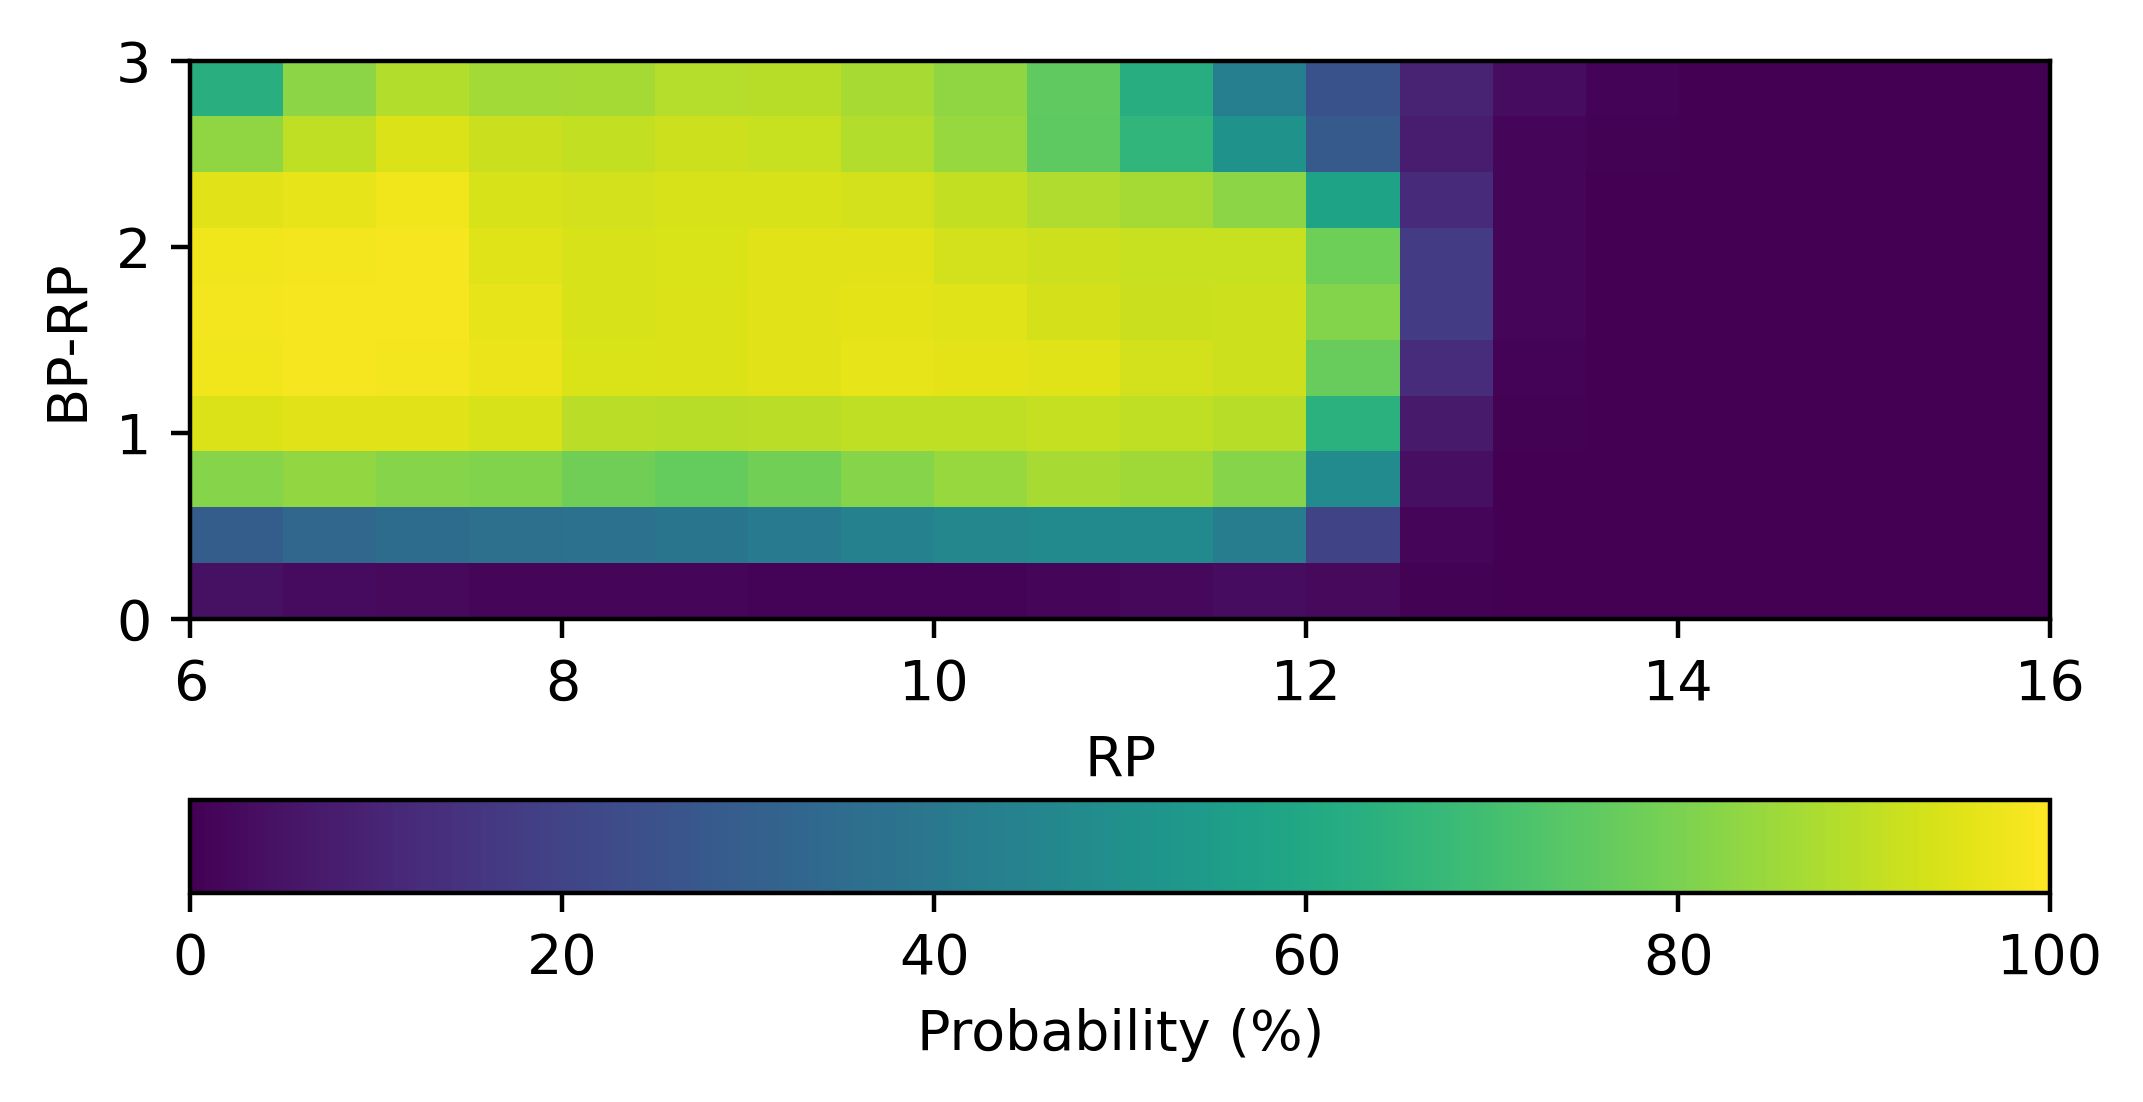

In [114]:
plt.imshow(100*special.expit(comp_x.mean(axis=0)),origin='lower',vmin=0,vmax=100,extent=[6,16,0,3])
plt.xlabel('RP')
plt.ylabel('BP-RP')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('Probability (%)')

In [46]:
mcpsp_x.shape

(3072, 10, 20)

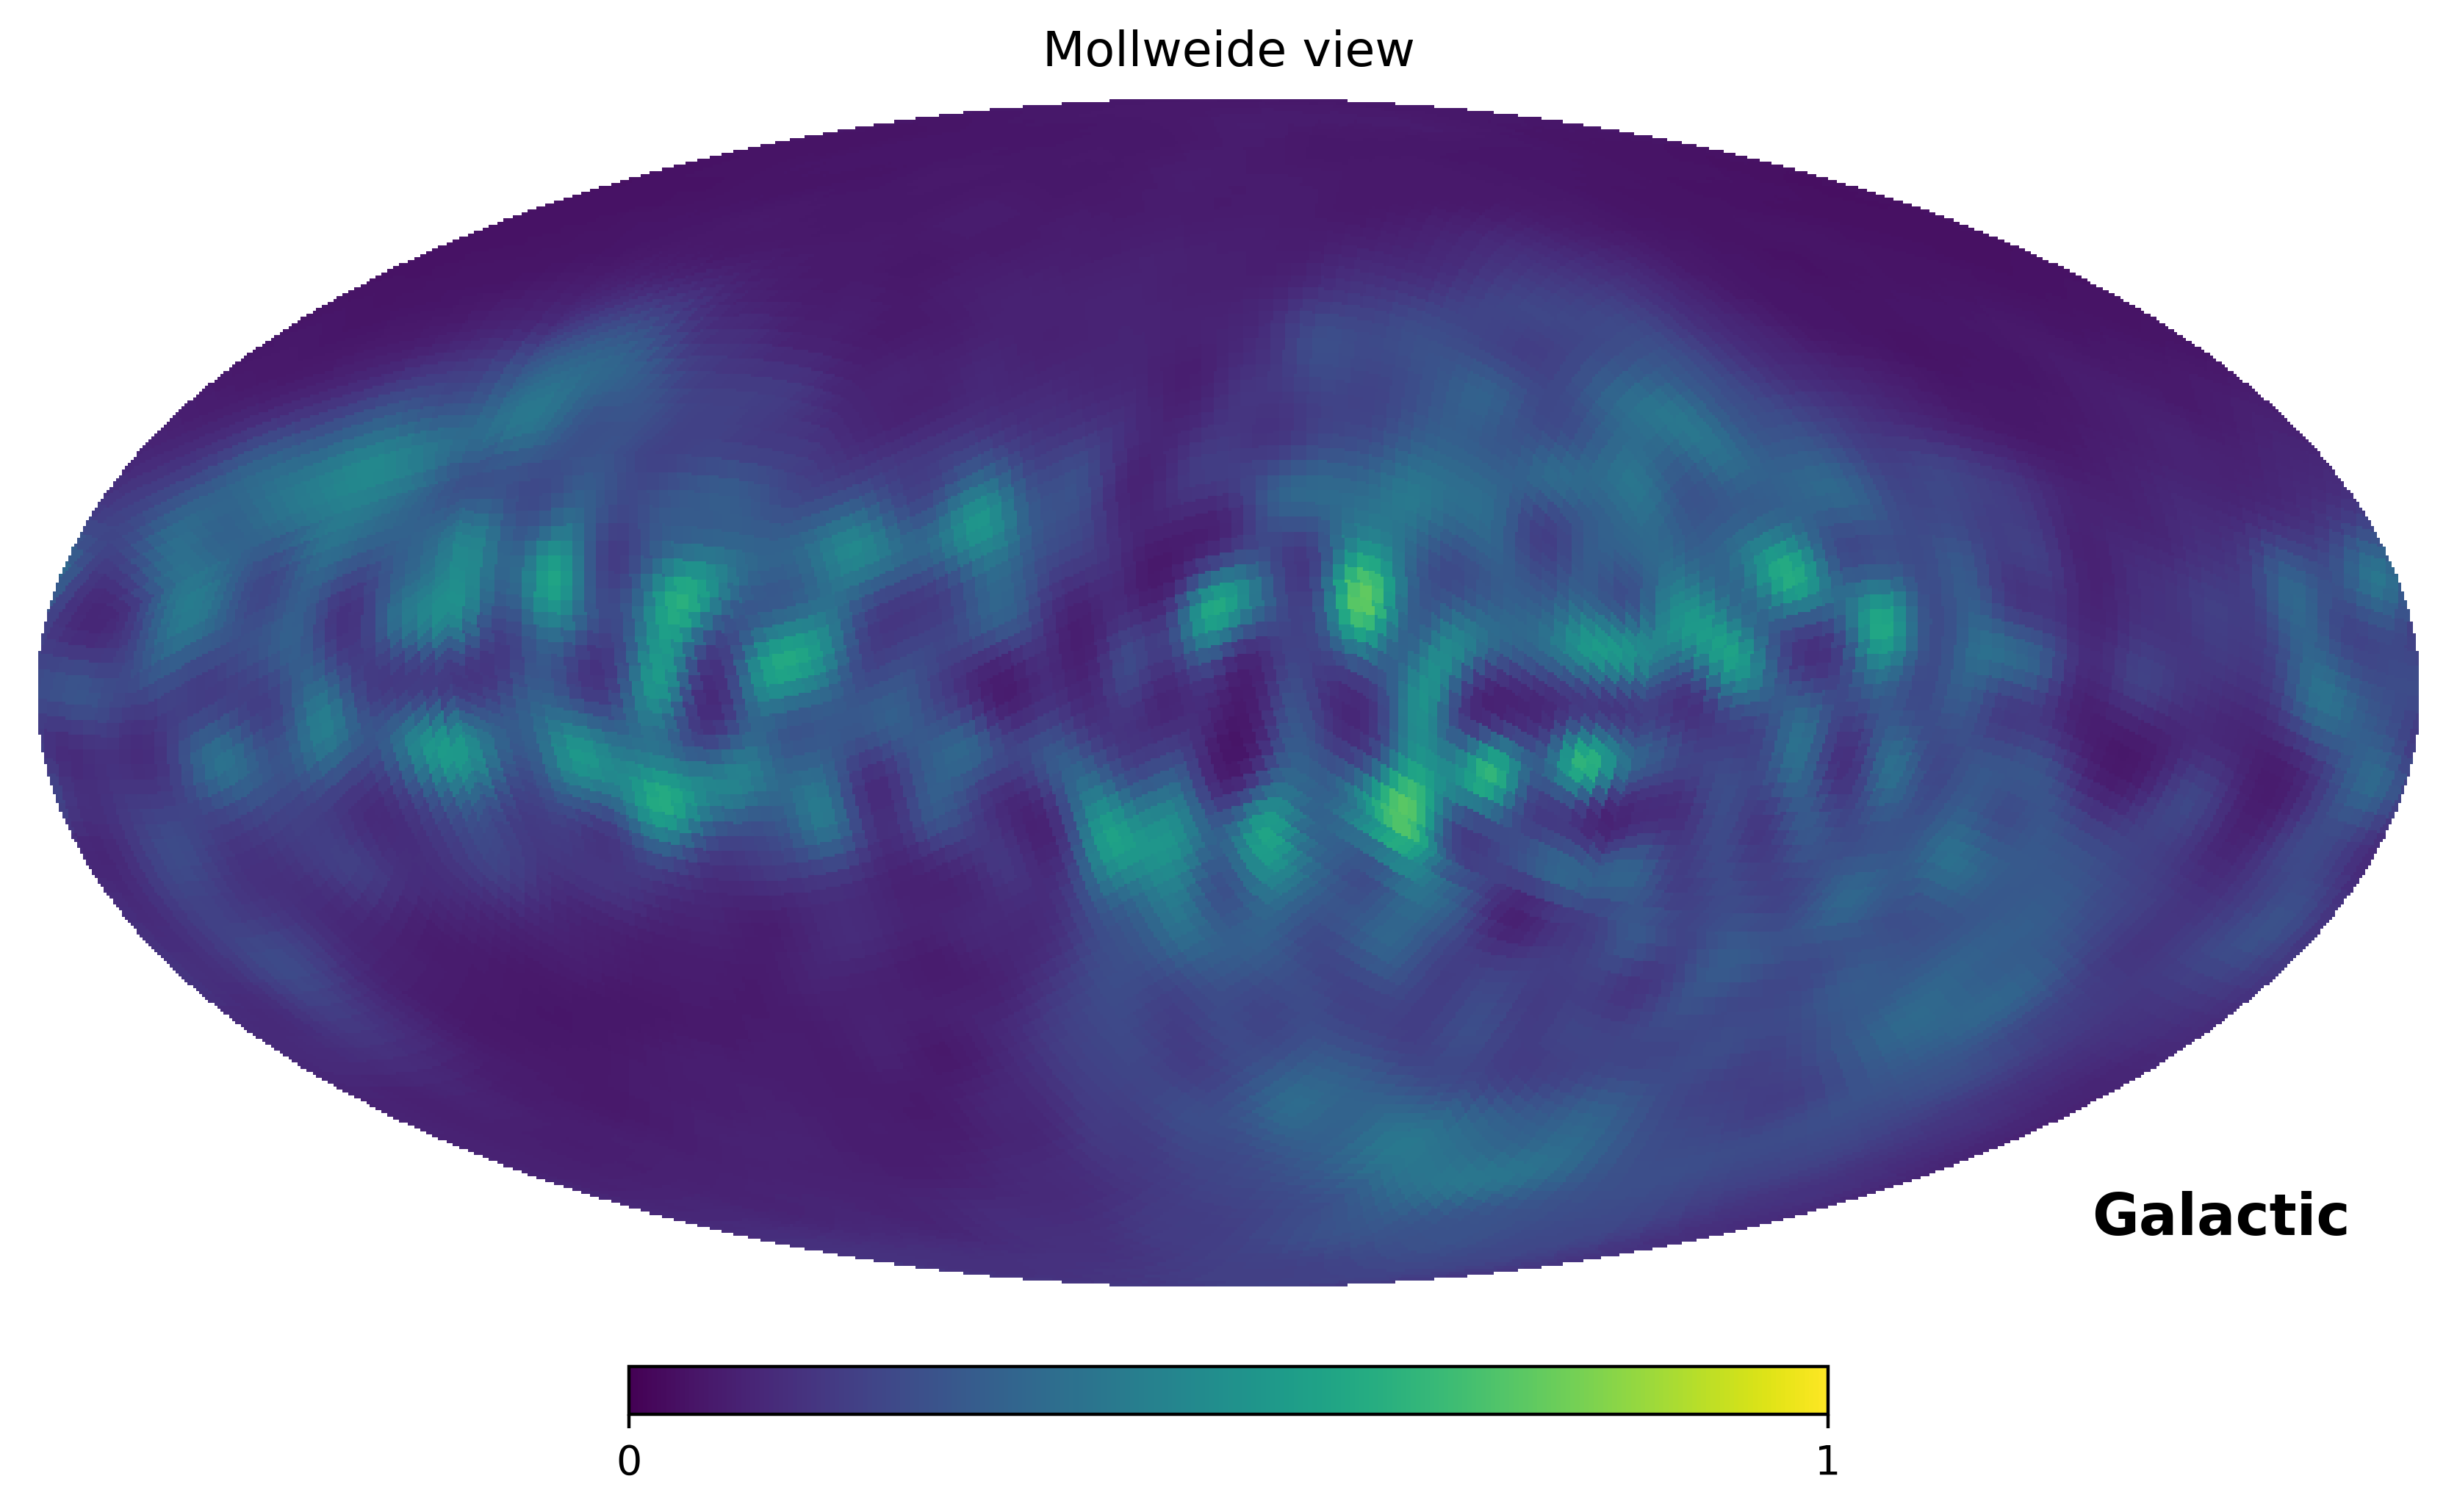

In [118]:
hp.mollview(special.expit(comp_x[:,5,13]),min=0,max=1,coord=['C','G'])

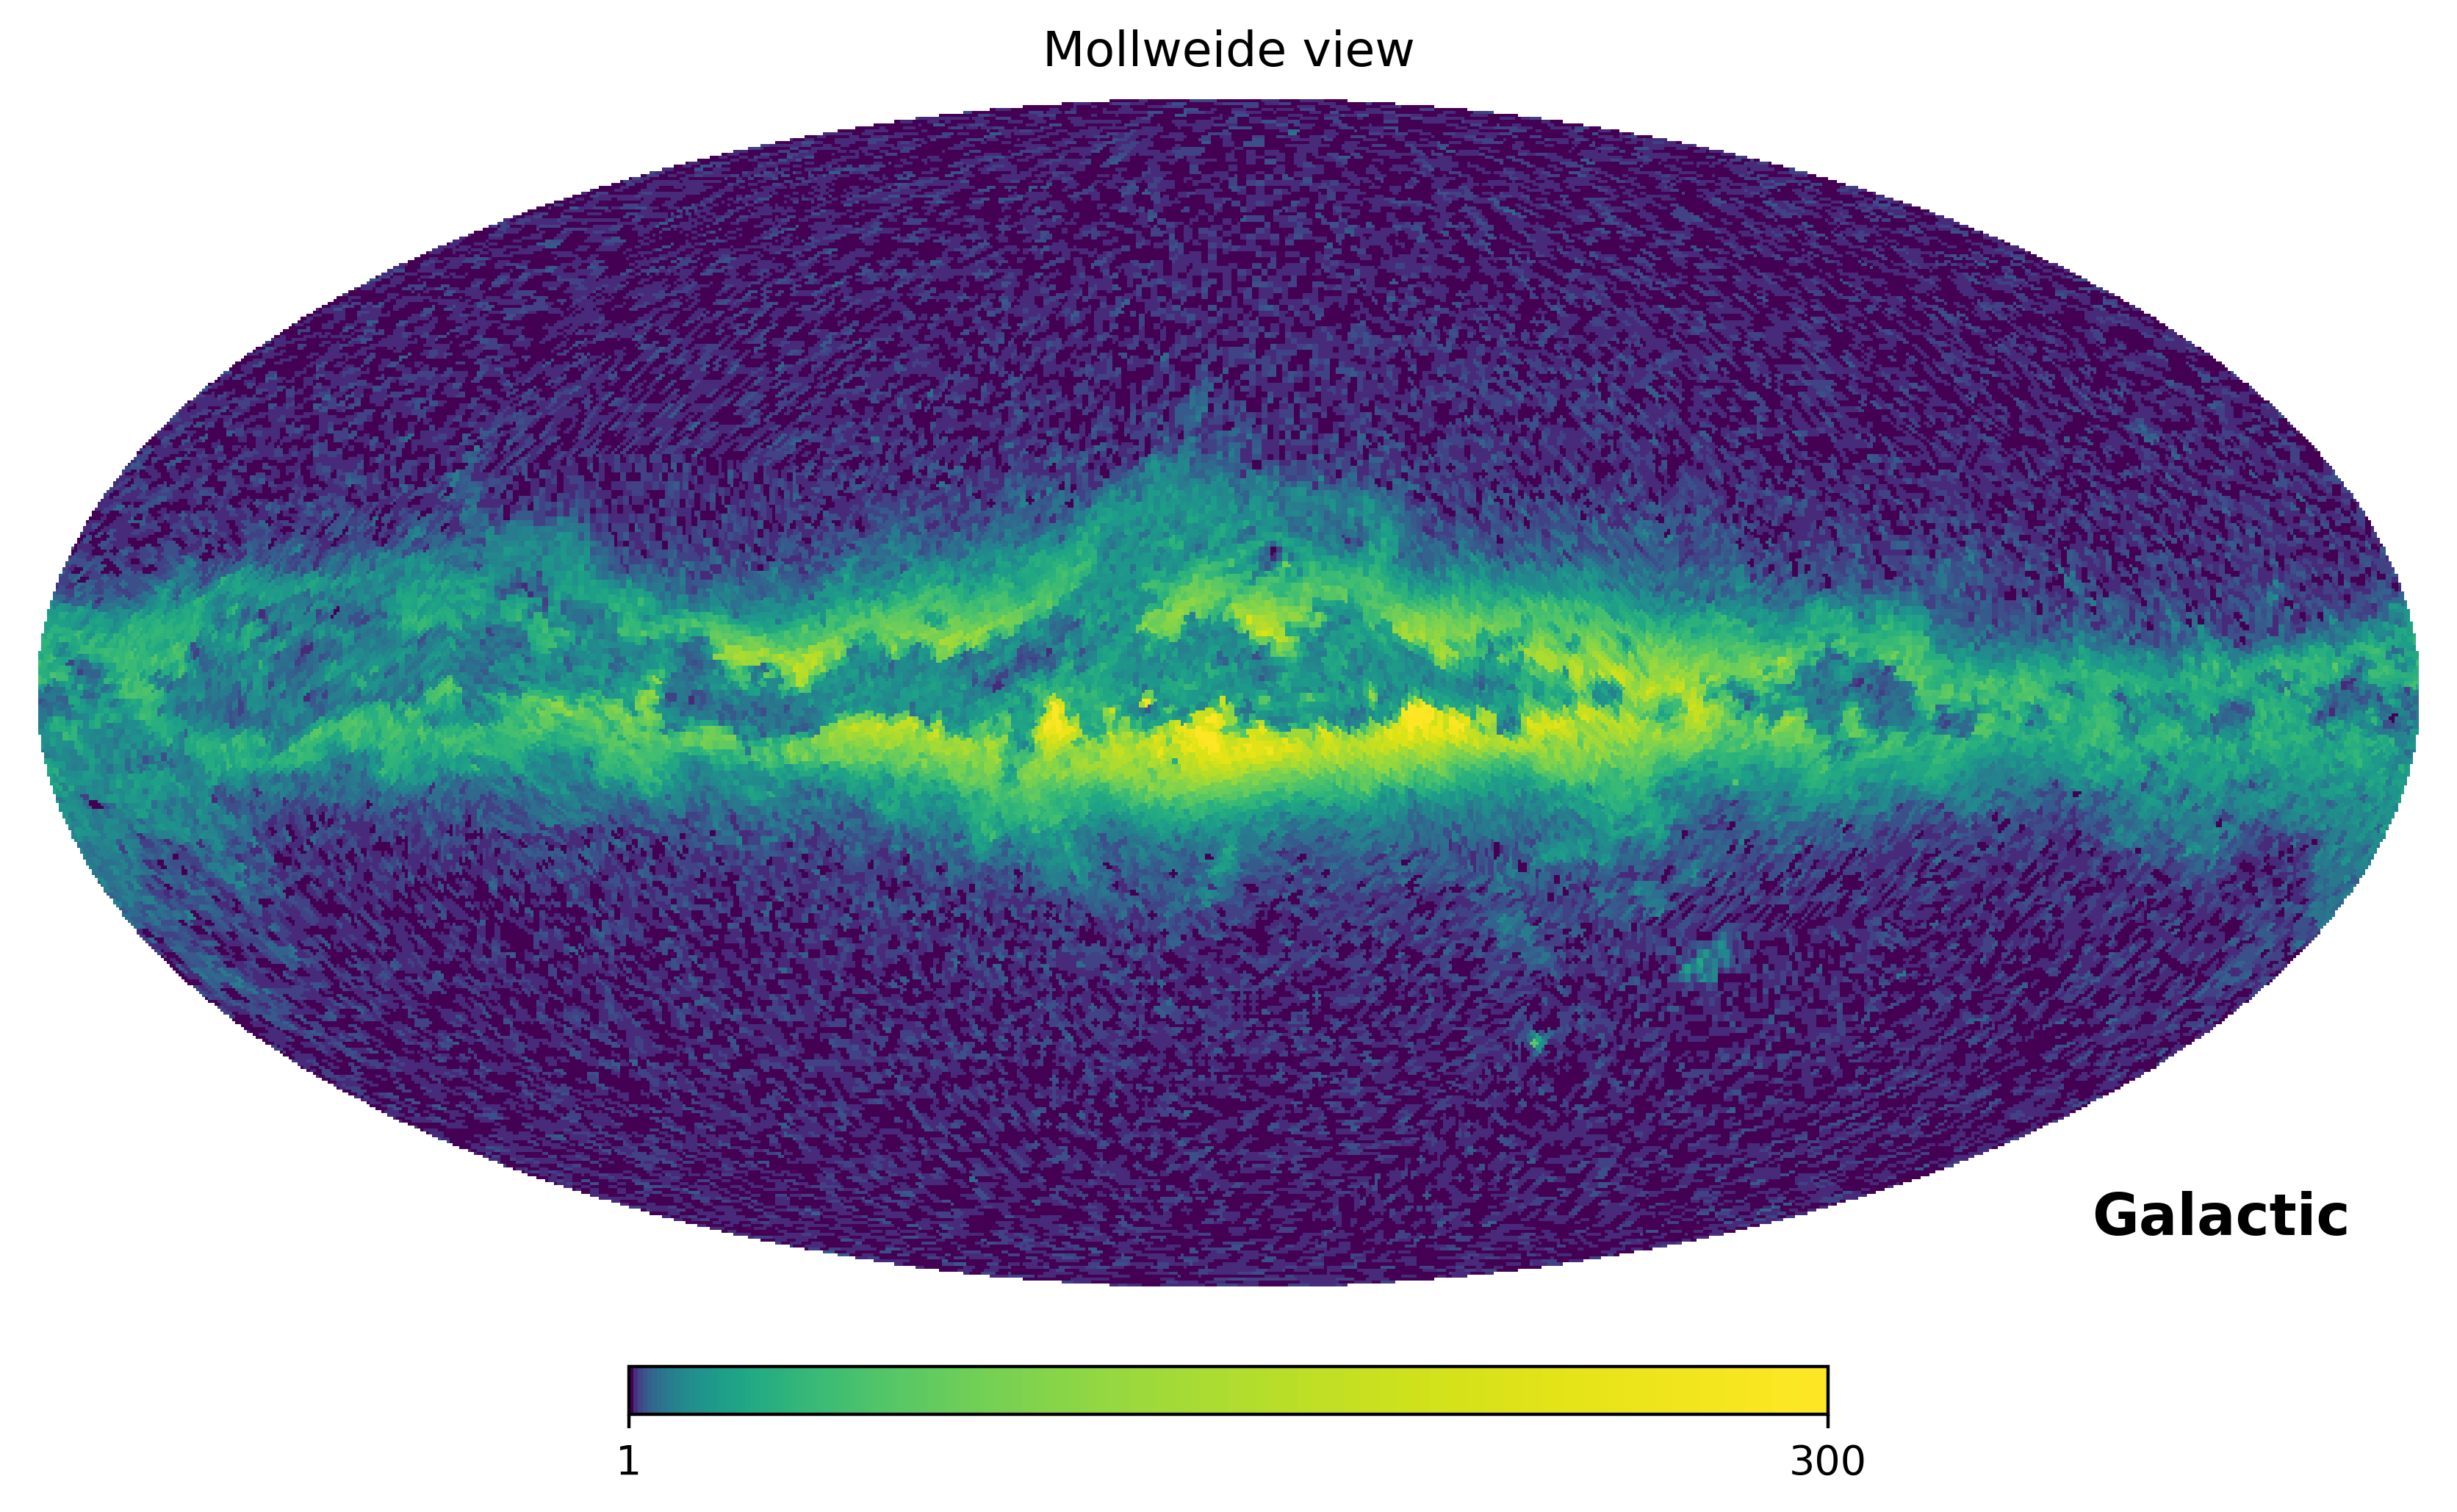

In [83]:
hp.mollview(1+box['n'][:,13,5],coord=['C','G'],norm='log',max=300)

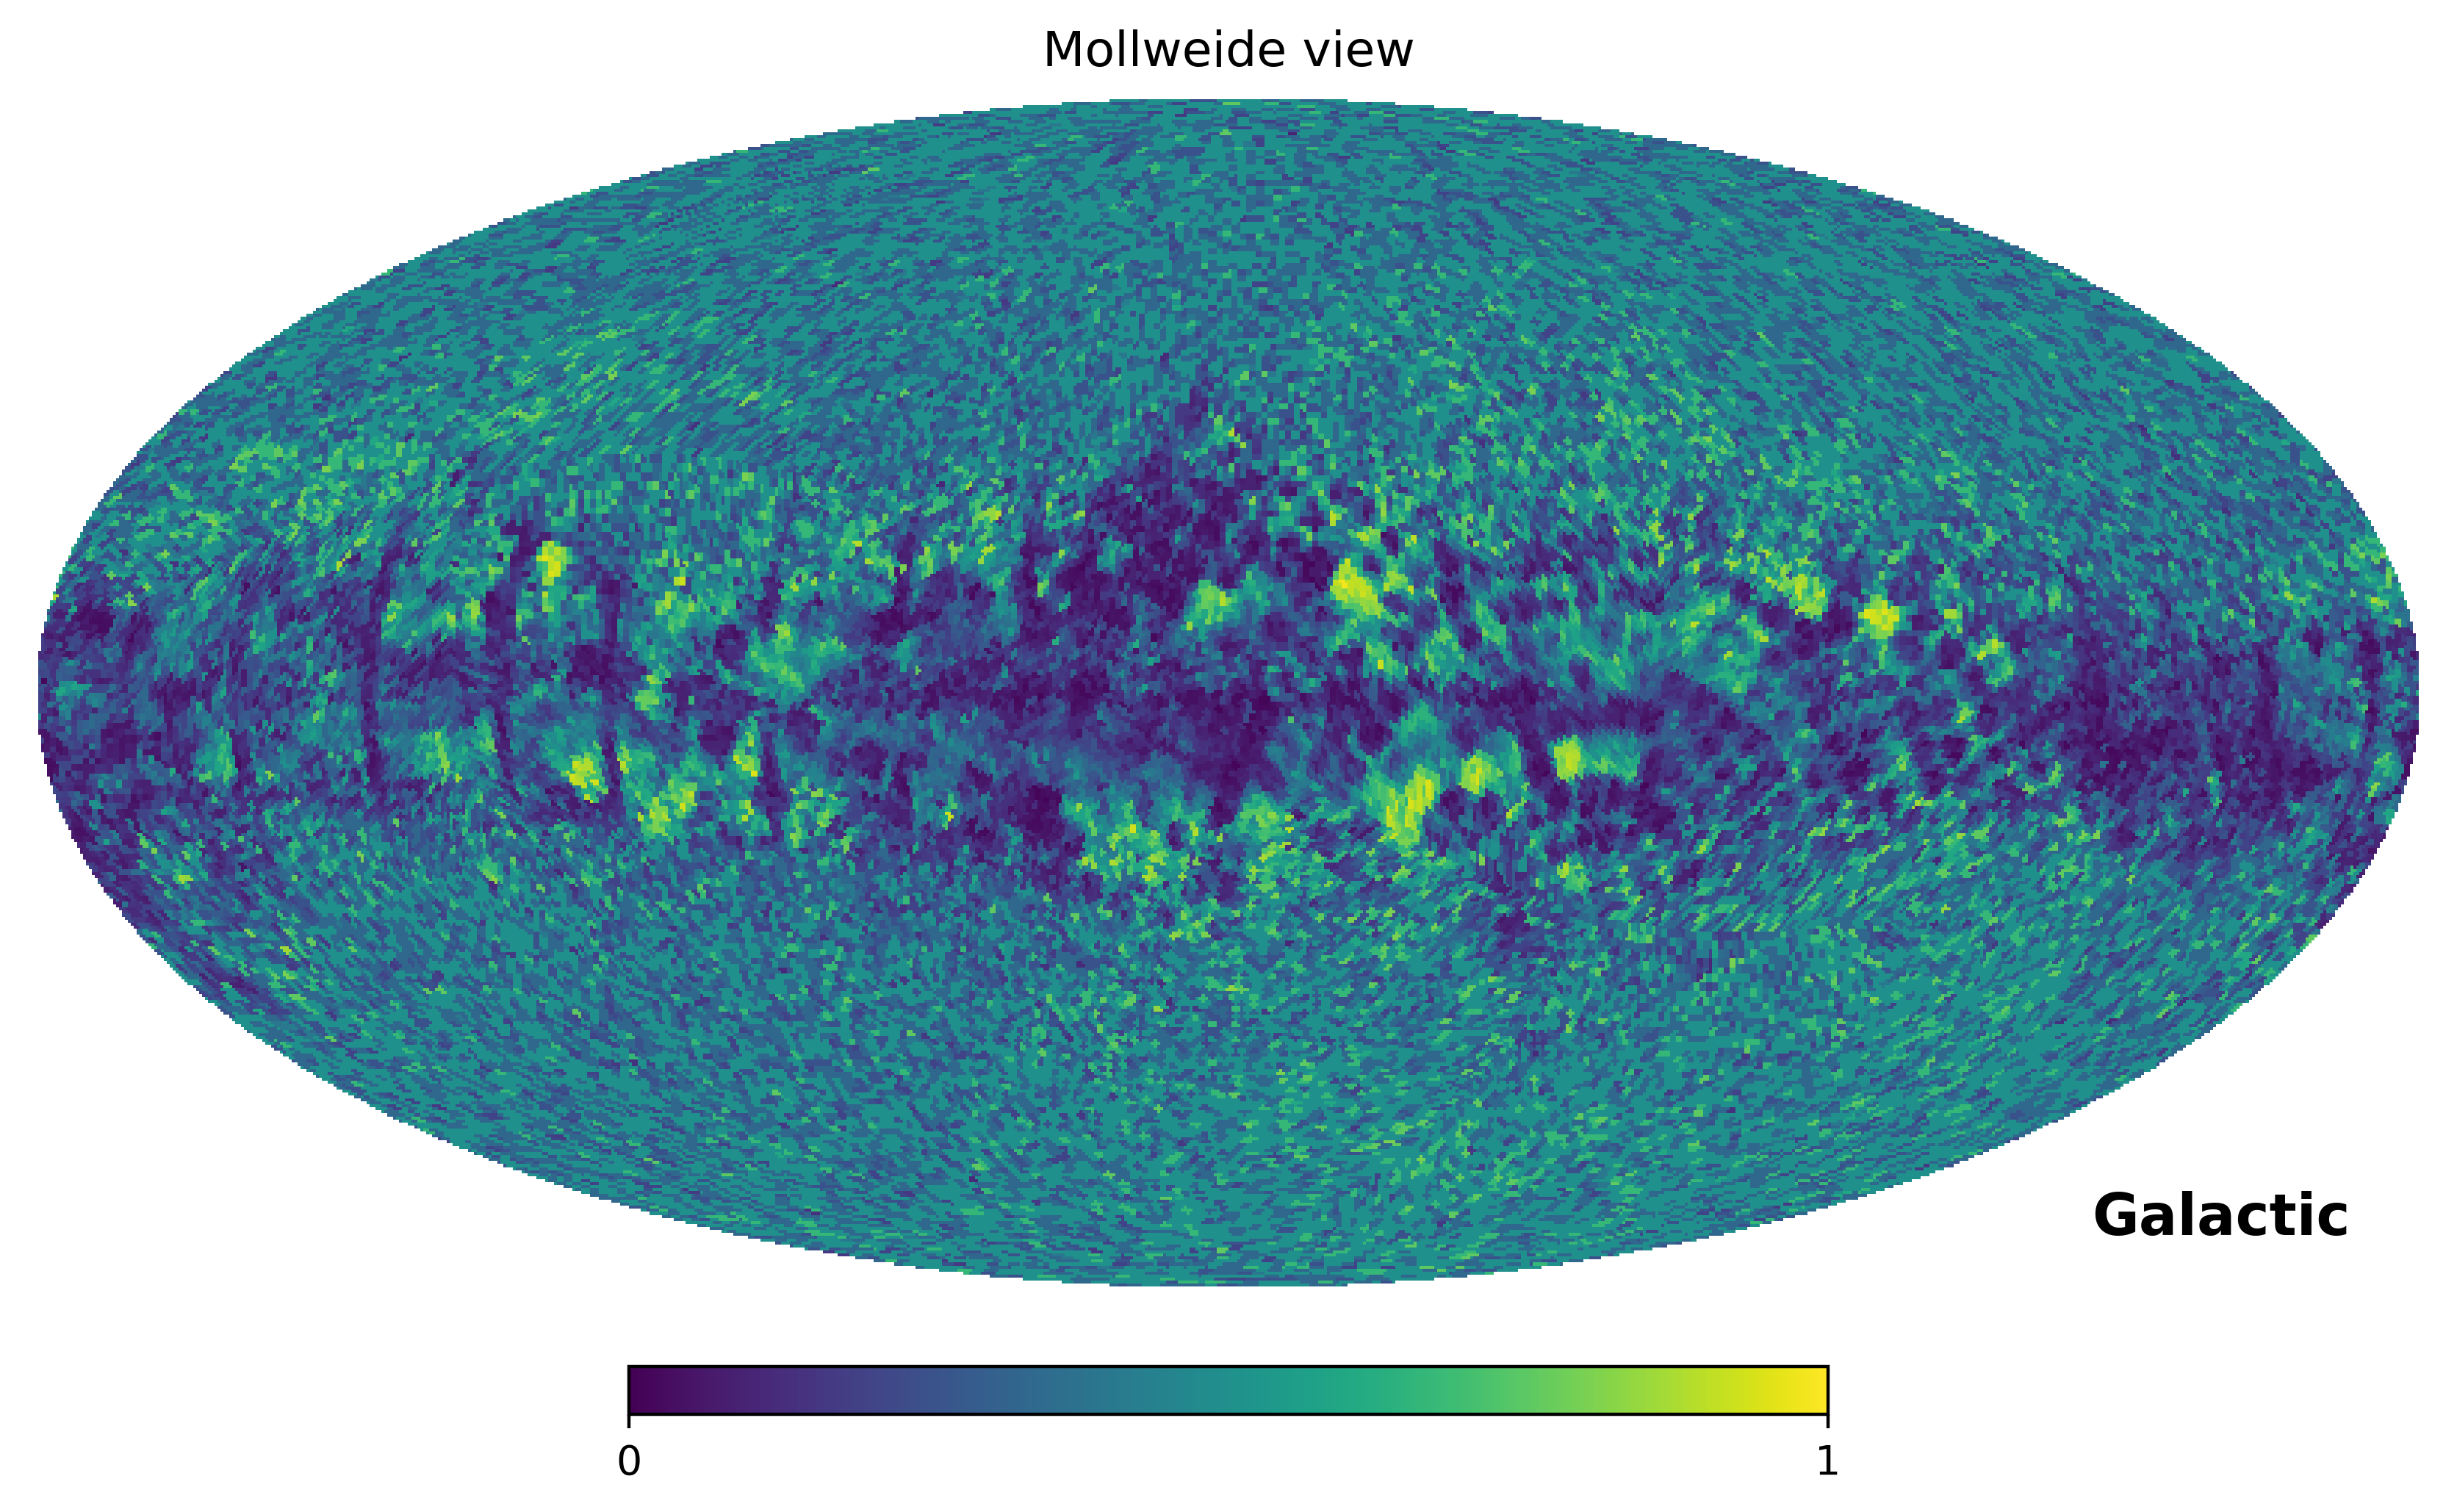

In [82]:
hp.mollview((box['k'][:,13,5]+1)/(box['n'][:,13,5]+2),min=0,max=1,coord=['C','G'])

In [ ]:
hp.mollview(special.expit(mcpsp_x[:,5,13]),min=0,max=1,coord=['C','G'])

In [ ]:
np.where(cholesky_m < 1e-2)[0].size

In [ ]:
approx_cholesky_m = cholesky_m.copy()
approx_cholesky_m[cholesky_m<1e-2] = 0.0
np.where(approx_cholesky_m == 0.0)

In [ ]:
z = np.random.normal(0,1,(M,C))
x = cholesky_m @ z @ cholesky_c.T
plt.imshow(x.T)

In [ ]:
x = approx_m @ z @ approx_c.T
plt.imshow(x.T)

In [ ]:
plt.imshow((approx_m @ z @ approx_c.T-cholesky_m @ z @ cholesky_c.T).T,cmap='RdBu')
plt.colorbar()

In [ ]:
z = np.random.normal(0,1,(pivot_m.shape[1],pivot_c.shape[1]))
x = pivot_m @ z @ pivot_c.T
plt.imshow(x.T)

In [ ]:
plt.imshow(R.T)
plt.colorbar()

In [ ]:
import os 
def tail(filename, lines=1, _buffer=4098):
    """Tail a file and get X lines from the end"""
    # place holder for the lines found
    lines_found = []

    # block counter will be multiplied by buffer
    # to get the block size from the end
    block_counter = -1
    
    with open(filename,'r') as f:
        # loop until we find X lines
        while len(lines_found) < lines:
            try:
                f.seek(block_counter * _buffer, os.SEEK_END)
            except IOError:  # either file is too small, or too many lines requested
                f.seek(0)
                lines_found = f.readlines()
                break

            lines_found = f.readlines()

            # we found enough lines, get out
            # Removed this line because it was redundant the while will catch
            # it, I left it for history
            # if len(lines_found) > lines:
            #    break

            # decrement the block counter to get the
            # next X bytes
            block_counter -= 1

    return lines_found[-lines:]

In [ ]:
for line in tail('./StanOutput/'+str(fit_opt).split('/')[-1],5):
    print(line)

In [ ]:
fit_opt_x = fit_opt.optimized_params_np[1+H*M*C:].reshape((P,C,M))

In [ ]:
plt.figure()
plt.imshow(special.expit(np.mean(fit_opt_x,axis=0)),vmin=0,vmax=1)

In [ ]:
np.array(fit_opt.column_names[1+H*M*C:]).reshape((P,C,M))[:,:,0].T

In [ ]:
hp.mollview(special.expit(fit_opt_x.mean(axis=1)[:,3]),coord=['C','G'],min=0,max=1)

In [ ]:
%time fit_hmc = mcp_model.sample(data=mcp_data, iter_warmup=100, iter_sampling=100, inits=0, chains=1, show_progress = 'notebook')

In [ ]:
%time mcpr_model = CmdStanModel(stan_file='./StanModels/magnitude_colour_position_reducesum.stan',cpp_options={"STAN_THREADS": True})

In [ ]:
parallel_fit = mcpr_model.sample(data=mcp_data, chains=1, parallel_chains=1, iter_warmup=100, iter_sampling=100, threads_per_chain=4, show_progress='notebook')

In [ ]:
%time %run ModelRVS.py 3 2 4 3 1.0

In [ ]:
with h5py.File('./ModelOutputs/lmax3_nside2_M4_C3_l1.0.h5', 'r') as f:
    x = f['x'][:]


In [ ]:
hp.mollview(x[:,1,1],coord=['C','G'])

In [ ]:
Nm,Nc,Nh = 4,3,2
xm,xc,xh = np.arange(Nm),np.arange(Nc),np.arange(Nh)
Km,Kc,Kh = np.exp(-np.abs(xm[:,None]-xm[None,:])),np.exp(-np.abs(xc[:,None]-xc[None,:])),np.diag([3.0,2.0])
K = np.kron(Kh,np.kron(Km,Kc))
x = np.random.normal(0,1,Nm*Nc*Nh)
answer = np.dot(K,x)
approx = np.zeros(Nm*Nc*Nh)
KmKc = np.kron(Km,Kc)
for i in range(Nh):
    approx[Nm*Nc*i:Nm*Nc*(i+1)] = Kh[i,i]*np.dot(KmKc,x[Nm*Nc*i:Nm*Nc*(i+1)])

In [ ]:
Nm,Nc,Nh = 4,3,2
xm,xc,xh = np.arange(Nm),np.arange(Nc),np.arange(Nh)
Km,Kc,Kh = np.exp(-np.abs(xm[:,None]-xm[None,:])),np.exp(-np.abs(xc[:,None]-xc[None,:])),np.diag([3.0,2.0])
K = np.kron(Kh,np.kron(Km,Kc))
X = np.random.normal(0,1,(Nh,Nm,Nc))
answer = np.dot(K,X.reshape((Nh*Nm*Nc,)))
approx = np.zeros(Nm*Nc*Nh)
KmKc = np.kron(Km,Kc)
for i in range(Nh):
    approx[Nm*Nc*i:Nm*Nc*(i+1)] = Kh[i,i]*np.einsum('ij,jk,kl->il',Km,X[i],Kc.T).reshape((Nm*Nc,))

In [ ]:
Nm,Nc,Nh = 4,3,2
xm,xc,xh = np.arange(Nm),np.arange(Nc),np.arange(Nh)
Km,Kc,Kh = np.exp(-np.abs(xm[:,None]-xm[None,:])),np.exp(-np.abs(xc[:,None]-xc[None,:])),np.diag([3.0,2.0])
K = np.kron(Kh,np.kron(Km,Kc))
X = np.random.normal(0,1,(Nh,Nm,Nc))
answer = np.dot(K,X.reshape((Nh*Nm*Nc,))).reshape((Nh,Nm,Nc))
approx = np.zeros((Nh,Nm,Nc))
KmKc = np.kron(Km,Kc)
for i in range(Nh):
    approx[i] = Kh[i,i]*np.einsum('ij,jk,kl->il',Km,X[i],Kc.T)

In [ ]:
answer

In [ ]:
approx

In [ ]:
plt.figure()
plt.imshow(theta.T,origin='lower')

In [ ]:
hp.mollview(hpx_theta,nest=True,coord=['C','G'])

In [ ]:
plt.figure()
plt.imshow(box['k'].sum(axis=(0)))

# Create Andy's grid

In [ ]:

# Form the l's and m's
Nmodes = int((lmax+1)**2)
Nmodes_hp = int((lmax+1)*(lmax+2)/2)
l_hp,m_hp = hp.sphtfunc.Alm.getlm(lmax=lmax)
assert Nmodes_hp == l_hp.size

l, m = np.zeros(Nmodes,dtype=np.int), np.zeros(Nmodes,dtype=np.int)
l[:Nmodes_hp],m[:Nmodes_hp] = l_hp,m_hp
l[Nmodes_hp:],m[Nmodes_hp:] = l_hp[lmax+1:],-m_hp[lmax+1:]

In [ ]:
sphox['m']

In [ ]:
m

In [ ]:
%time %run GenerateSphHarm_decomposed_quick.py $nside $lmax

with h5py.File(f'./sphericalharmonics_decomposed_quick_nside{nside}_lmax{lmax}.h5', 'r') as f:
    sphox = {k:v[:] for k,v in f.items()}
    
sphox.keys()

from GenerateSphHarm_decomposed import real_harmonics
sphox['Ylm'] = real_harmonics(sphox['lambda'], sphox['azimuth'], sphox['m'], lmax, sphox['jpix'])

In [ ]:
%%time
binomial_code = """
    data {
      int<lower=0> J;            // number of pixels
      int<lower=0> Nring;        // number of HEALPix isolatitude rings
      int<lower=0> H;            // number of harmonics
      int<lower=0> lmax;         // max l of hamonics
      int k[J];               // astrometry sample counts
      int n[J];               // full sample counts
      matrix[Nring,H] lambda;    // spherical harmonics decomposed
      matrix[J,2*lmax+1] azimuth;// spherical harmonics decomposed
      int jpix[J];
      int lower[2*lmax+1];
      int upper[2*lmax+1];
    }
    parameters {
      vector[H] alm;               // logit selection probability
    }
    transformed parameters {
        vector[J] x;
        {
        matrix[Nring,2*lmax+1] F;
        for (i in 1:2*lmax+1) {
            F[:,i] = lambda[:,lower[i]:upper[i]] * alm[lower[i]:upper[i]];
        }
        x = rows_dot_product(F[jpix],azimuth);
        }
    }
    model {
      alm ~ std_normal();
      k ~ binomial_logit(n, x);
    }
    """
import pystan
bn = pystan.StanModel(model_code=binomial_code)

In [ ]:
binomial_code = """
data {
    int<lower=0> J;        // number of pixels
    int<lower=0> N;        // number of HEALPix isolatitude rings
    int<lower=0> H;        // number of harmonics
    int<lower=0> L;        // 2 * max l of hamonics + 1
    matrix[N,H] lambda;    // spherical harmonics decomposed
    matrix[J,L] azimuth;   // spherical harmonics decomposed
    int indices[J];        // map N->J
    int lower[L];          // map H->L
    int upper[L];          // map H->L
    int k[J];
    int n[J];
}
parameters {
    vector[H] alm;
}
transformed parameters {
    vector[J] x;
    {
        matrix[N,L] F;
        for (i in 1:L) {
            F[:,i] = lambda[:,lower[i]:upper[i]] * alm[lower[i]:upper[i]];
        }
        x = rows_dot_product(F[indices],azimuth);
    }
}
model {
    alm ~ std_normal();
    k ~ binomial_logit(n, x);
}
    """

In [ ]:
nside = 64
N_pixels = hp.nside2npix(nside)
N_sources = 1811709771
N_chunk = 3*17*6791
N_block = 5231
keys = ['source_id','phot_g_mean_mag','bp_rp','dr2_radial_velocity']

min_phot_g_mean_mag, max_phot_g_mean_mag = 100.0, 0.0
min_bp_rp, max_bp_rp = 100.0, 0.0

eps = 1e-10
bins = {'healpix':np.arange(-0.5,N_pixels),'phot_rp_mean_mag':np.arange(6.0,16.0+eps,0.1),'bp_rp':np.arange(0.0,3.0+eps,0.1)}
bins_sizes = [bins[k].size-1 for k in ['healpix','phot_rp_mean_mag','bp_rp']]


In [ ]:
nside = 128
N_pixels = hp.nside2npix(nside)
N_level = hp.nside2order(nside)
healpix_factor = 2**(59-2*N_level)

In [ ]:
healpix_factor

In [ ]:
nside = 32
lmax = 100

%time %run GenerateSphHarm_decomposed_quick.py $nside $lmax

l = hp.sphtfunc.Alm.getlm(lmax=lmax-1)[0]
scale = 10.0/(1.0+l)**2
_alm = np.random.normal(0,scale,int(lmax*(lmax+1)/2)) + 1j*np.random.normal(0,scale,int(lmax*(lmax+1)/2))
_map = hp.sphtfunc.alm2map(_alm,nside=nside,verbose=False)

sample = {}
sample['hpx'] = np.random.choice(np.arange(hp.nside2npix(nside)), size=int(1e7), replace=True)
sample['p'] = special.expit(_map[sample['hpx']])
sample['selected'] = (np.random.rand(len(sample['hpx'])) < sample['p']).astype(int)

k = stats.binned_statistic(sample['hpx'], sample['selected'],
                       bins=np.arange(hp.nside2npix(nside)+1)-0.5, statistic='sum').statistic
n = stats.binned_statistic(sample['hpx'], sample['selected'],
                       bins=np.arange(hp.nside2npix(nside)+1)-0.5, statistic='count').statistic

hp.mollview(special.expit(_map),min=0,max=1,cmap='viridis')

data = {}
with h5py.File('./sphericalharmonics_decomposed_quick_nside{0}_lmax{1}.h5'.format(nside,lmax), 'r') as hf:
    for key in hf.keys():
        data[key] = hf[key][...]
        
lower, upper = np.zeros(2*lmax+1),np.zeros(2*lmax+1)
for i, _m in enumerate(range(-lmax,lmax+1)):
    match = np.where(m==_m)[0]
    lower[i] = match[0]
    upper[i] = match[-1]

binomial_data = {"J":hp.nside2npix(nside),
                 "Nring":data['lambda'].shape[1],
                 "H":data['m'].shape[0],
                 "lmax":lmax,
                 "k": k.astype(np.int),
                 "n": n.astype(np.int),
                 "lambda":data['lambda'].T,
                 "azimuth":data['azimuth'].T,
                 "jpix":data['jpix']+1,
                 "lower":lower.astype(np.int)+1,
                 "upper":upper.astype(np.int)+1}


In [ ]:
%time fit_vb = bn.vb(data=binomial_data,output_samples=100)

In [ ]:
%time fit_vb = bn.vb(data=binomial_data,output_samples=100,init=fit_opt['alm'])

In [ ]:
%time fit_opt = bn.optimizing(data=binomial_data)

In [ ]:
hp.mollview(special.expit(fit_opt['x']),min=0,max=1,cmap='viridis')

In [ ]:
hp.nside2resol(64,arcmin=True)/60

In [ ]:
180/1.8

In [ ]:
Nmode = (lmax+1)**2
Npix = hp.nside2npix(nside)
fit_x = np.array([ np.median(fit_vb['sampler_params'][i]) for i in range(Nmode,Nmode+Npix)])
fit_alm = np.array([ np.median(fit_vb['sampler_params'][i]) for i in range(Nmode)])
hp.mollview(special.expit(fit_x),min=0,max=1,cmap='viridis')

In [ ]:
%time fit = bn.sampling(data=binomial_data, iter=100, chains=1, n_jobs=1, init=[{'alm':fit_alm}])

In [ ]:
hp.mollview(special.expit(np.median(fit['x'],axis=0)),min=0,max=1,cmap='viridis')

In [ ]:
fit = bn.sampling(data=binomial_data, iter=100, chains=1, n_jobs=1, init = )

In [ ]:
plt.figure()

plt.plot(x,binomial)

In [ ]:
x = np.linspace(-5,5,1001)
p = special.expit(x)
k = 2
n = 3
binomial = stats.binom(n=n,p=p).pmf(k)

def phi(x,mu,sigma):
    return stats.norm(loc=mu,scale=sigma).pdf(x)

def Phi(x,mu,sigma):
    return stats.norm(loc=mu,scale=sigma).cdf(x)

def model_phiPhi(y):
    return y[0]*phi(x,y[1],np.exp(y[2]))*Phi(x,y[3],np.exp(y[4]))

def model_skew(y):
    X = (x-y[1])/np.exp(y[2])
    return y[0]*2*phi(X,0,1)*Phi(X*y[3],0,1)

def model_Phi(y):
    return y[0]*Phi(x,y[1],np.exp(y[2]))

def target_phiPhi(y):
    return np.square(model_phiPhi(y)-binomial).sum()

def target_skew(y):
    return np.square(model_skew(y)-binomial).sum()

def target_Phi(y):
    return np.square(model_Phi(y)-binomial).sum()

from scipy import optimize
res_phiPhi = optimize.minimize(target_phiPhi,np.zeros(5))
res_skew = optimize.minimize(target_skew,np.zeros(4))
res_Phi = optimize.minimize(target_Phi,np.zeros(3))
#print(res_)

plt.figure()
plt.plot(x,binomial)
plt.plot(x,model_phiPhi(res_phiPhi.x))
plt.plot(x,model_skew(res_skew.x))
plt.plot(x,model_Phi(res_Phi.x))

In [ ]:
res_skew

In [ ]:
x = np.linspace(-20,20,1001)
p = special.expit(x)
k = 1
n = 12
binomial = stats.binom(n=n,p=p).pmf(k)
X = res.x.copy()
X[1] *= -1
X[3] *= -1

plt.figure()
plt.plot(x,binomial)
plt.plot(x,model(X))

